In [1]:
import os
import random
import pandas as pd
import numpy as np
from box import Box

from sklearn.preprocessing import LabelEncoder

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import copy

from typing import Tuple
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
def setSeed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

In [3]:
dir_base = os.path.join(os.path.join('/opt','ml','paper','RecSys'))
dir_data = os.path.join(dir_base, 'Data', 'ml-latest-small')
path_rating = os.path.join(dir_data, 'ratings.csv')
dir_file_path = {
    'dir_base': dir_base,
    'dir_data': dir_data,
    'path_rating': path_rating,
}

dir_file_path = Box(dir_file_path)

In [4]:
class DataInfo():
    def __init__(self, file_path: str) -> None:
        self.df = pd.read_csv(file_path)
        self.user_encoder, self.movie_encoder = self._encode()

        self.set_users = set(self.df['userId'].unique())
        self.num_users = len(self.set_users)
        self.set_movies = set(self.df['movieId'].unique())
        self.num_movies = len(self.set_movies)

    def _encode(self) -> Tuple[pd.DataFrame, LabelEncoder, LabelEncoder]:
        userId_label_encoder = LabelEncoder()
        movieId_label_encoder = LabelEncoder()

        self.df['userId'] = userId_label_encoder.fit_transform(self.df['userId'].values)
        self.df['movieId'] = movieId_label_encoder.fit_transform(self.df['movieId'].values)

        # encoder.inverse_transform() 으로 decode
        return userId_label_encoder, movieId_label_encoder

In [5]:
class MFDataSet(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):

        # nn.Embedding은 input 타입이 정수이어야 한다.
        user = torch.tensor(self.df.iloc[idx]['userId']).to(torch.int64)
        item = torch.tensor(self.df.iloc[idx]['movieId']).to(torch.int64)
        rating = torch.tensor(self.df.iloc[idx]['rating']).float()

        return user, item, rating, torch.Tensor(0)

In [6]:
class BPRDataSet(Dataset):
    def __init__(self, data):
        self.df = data.df
        self.items = data.set_movies

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        user = torch.tensor(self.df.iloc[idx]['userId']).to(torch.int64)
        item = torch.tensor(self.df.iloc[idx]['movieId']).to(torch.int64) # self.df.iloc[idx]['movieId']
        rating = torch.tensor(self.df.iloc[idx]['rating']).float()

        neg_item = self._choiceRandomItem(user, item, rating)
        neg_item = torch.tensor(neg_item).to(torch.int64)

        return user, item, rating, neg_item
    
    def _choiceRandomItem(self, user, item, rating):
        user = int(user.detach().cpu().numpy())
        item = int(item.detach().cpu().numpy())
        rating = float(rating.detach().cpu().numpy())
        
        candi_item = list(self.items - set([item]))
        choice_item = int(random.sample(candi_item, 1)[0])

        choice_rating = self.df[(self.df['userId'] == user) & (self.df['movieId'] == choice_item)]['rating']
        
        while (not choice_rating.empty) and (rating <= choice_rating.values):
            choice_item = int(random.sample(candi_item, 1)[0])
            choice_rating = self.df[(self.df['userId'] == user) & (self.df['movieId'] == choice_item)]['rating']
        
        return choice_item

In [7]:
class MF(nn.Module):
    def __init__(self, num_users, num_items, latent_dim, global_mean):
        super(MF, self).__init__()
        self.user_embedding = nn.Embedding(num_users, latent_dim)
        self.item_embedding = nn.Embedding(num_items, latent_dim)
        self.user_bias_embedding = nn.Embedding(num_users, 1)
        self.item_bias_embedding = nn.Embedding(num_items, 1)
        self.global_mean = global_mean

        self._init_weights()   

    def _init_weights(self):
        nn.init.xavier_uniform_(self.user_embedding.weight)
        nn.init.xavier_uniform_(self.item_embedding.weight)
        self.user_bias_embedding.weight.data.fill_(1)
        self.item_bias_embedding.weight.data.fill_(1)
    
    def forward(self, indices_user, indices_item):
        user_latent = self.user_embedding(indices_user)
        item_latent = self.item_embedding(indices_item)

        product = torch.sum(user_latent * item_latent, axis=1)

        user_bias = self.user_bias_embedding(indices_user).squeeze()
        item_bias = self.item_bias_embedding(indices_item).squeeze()


        output = self.global_mean + user_bias + item_bias + product
        return output

In [8]:
class BPRLoss(nn.Module):
    def __init__(self):
        super(BPRLoss, self).__init__()
        self.logsigmoid = nn.LogSigmoid()
    
    def forward(self, positive, negative):
        distances = positive - negative
        loss = -torch.mean(self.logsigmoid(distances))
        return loss

In [9]:
def train(model, data_loader, criterion, optimizer, epochs, device):
    model.to(device)
    model.train()
    
    loss_list = list()
    size = len(data_loader)

    # 훈련 시간 측정
    epoch_start = torch.cuda.Event(enable_timing=True)
    epoch_end = torch.cuda.Event(enable_timing=True)

    for epoch in range(epochs):
        epoch_loss = 0

        # 시작 시간 기록
        epoch_start.record()

        for user, item, rating, neg_item in tqdm(data_loader):
            user = user.to(device)
            item = item.to(device)
            rating = rating.to(device)

            optimizer.zero_grad()
            
            if neg_item.nelement() == 0:
                # MF
                pred = model(user, item)
                loss = criterion(pred, rating)
            else:
                # BPR
                neg_item = neg_item.to(device)
                pos = model(user, item)
                neg = model(user, neg_item)
                loss = criterion(pos, neg)
            
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        
        epoch_end.record()
        torch.cuda.synchronize()

        avg_loss = epoch_loss / size
        loss_list.append(avg_loss)

        print(
            f'Epoch[{epoch+1}/{epochs}]\ttrain_loss: {avg_loss:.4f}' +
            f'\t훈련시간: {epoch_start.elapsed_time(epoch_end)/1000:.2f} sec'
        )

    return loss_list

In [10]:
setSeed(42)
data = DataInfo(dir_file_path.path_rating)

In [11]:
hyper = {
    'latent_dim': 20,
    'learning_rate': 0.01,
    'epochs': 10,
    'batch_size': 128,
}

hyper = Box(hyper)

In [12]:
config = {
    'gpu_idx': 0,
    'criterion': 'adam',
}

config = Box(config)

device = torch.device(f"cuda:{config.gpu_idx}" if torch.cuda.is_available() else "cpu")
global_mean = data.df['rating'].mean()

model_mf = MF(data.num_users, data.num_movies, hyper.latent_dim, global_mean)
model_bpr = copy.deepcopy(model_mf) # BPR_MF(data.num_users, data.num_movies, hyper.latent_dim, global_mean)

In [13]:
dataset_mf = MFDataSet(df=data.df)
data_loader_mf = DataLoader(dataset_mf, batch_size=hyper.batch_size, shuffle=True)
optimizer_mf = torch.optim.Adam(model_mf.parameters(), lr=hyper.learning_rate, amsgrad=True) # weight_decay = 0.2를 하면 학습이 안 된다....
criterion_mf = nn.MSELoss()

In [14]:
dataset_bpr = BPRDataSet(data=data)
data_loader_bpr = DataLoader(dataset_bpr, batch_size=hyper.batch_size, shuffle=True)
optimizer_bpr = torch.optim.Adam(model_bpr.parameters(), lr=hyper.learning_rate, amsgrad=True) # weight_decay = 0.2를 하면 학습이 안 된다....
criterion_bpr = BPRLoss()

In [15]:
mf_loss = train(model_mf, data_loader_mf, criterion_mf, optimizer_mf, hyper.epochs, device)

  0%|          | 2/788 [00:00<00:46, 16.92it/s]

Epoch[1/10]	train_loss: 1.4922	훈련시간: 39.17 sec


  0%|          | 2/788 [00:00<00:56, 13.79it/s]

Epoch[2/10]	train_loss: 0.6622	훈련시간: 38.59 sec


  0%|          | 2/788 [00:00<00:49, 15.94it/s]

Epoch[3/10]	train_loss: 0.4588	훈련시간: 38.66 sec


  0%|          | 1/788 [00:00<01:44,  7.56it/s]

Epoch[4/10]	train_loss: 0.3719	훈련시간: 38.76 sec


  0%|          | 1/788 [00:00<01:20,  9.76it/s]

Epoch[5/10]	train_loss: 0.3265	훈련시간: 38.88 sec


  0%|          | 2/788 [00:00<01:01, 12.79it/s]

Epoch[6/10]	train_loss: 0.2999	훈련시간: 38.81 sec


  0%|          | 2/788 [00:00<00:50, 15.67it/s]

Epoch[7/10]	train_loss: 0.2788	훈련시간: 39.12 sec


  0%|          | 2/788 [00:00<00:42, 18.39it/s]

Epoch[8/10]	train_loss: 0.2652	훈련시간: 38.61 sec


  0%|          | 2/788 [00:00<00:42, 18.54it/s]

Epoch[9/10]	train_loss: 0.2536	훈련시간: 38.76 sec


100%|██████████| 788/788 [00:38<00:00, 20.22it/s]

Epoch[10/10]	train_loss: 0.2453	훈련시간: 38.97 sec


In [16]:
bpr_loss = train(model_bpr, data_loader_bpr, criterion_bpr, optimizer_bpr, hyper.epochs, device)

  0%|          | 0/788 [00:00<?, ?it/s]

Epoch[1/10]	train_loss: 0.4094	훈련시간: 153.85 sec


  0%|          | 0/788 [00:00<?, ?it/s]

Epoch[2/10]	train_loss: 0.2382	훈련시간: 147.49 sec


  0%|          | 0/788 [00:00<?, ?it/s]

Epoch[3/10]	train_loss: 0.1774	훈련시간: 143.80 sec


  0%|          | 0/788 [00:00<?, ?it/s]

Epoch[4/10]	train_loss: 0.1488	훈련시간: 157.36 sec


  0%|          | 0/788 [00:00<?, ?it/s]

Epoch[5/10]	train_loss: 0.1320	훈련시간: 152.14 sec


  0%|          | 0/788 [00:00<?, ?it/s]

Epoch[6/10]	train_loss: 0.1204	훈련시간: 152.60 sec


  0%|          | 0/788 [00:00<?, ?it/s]

Epoch[7/10]	train_loss: 0.1179	훈련시간: 151.89 sec


  0%|          | 0/788 [00:00<?, ?it/s]

Epoch[8/10]	train_loss: 0.1090	훈련시간: 151.09 sec


  0%|          | 1/788 [00:00<02:36,  5.03it/s]

Epoch[9/10]	train_loss: 0.1074	훈련시간: 151.04 sec


100%|██████████| 788/788 [02:30<00:00,  5.23it/s]

Epoch[10/10]	train_loss: 0.1025	훈련시간: 150.58 sec


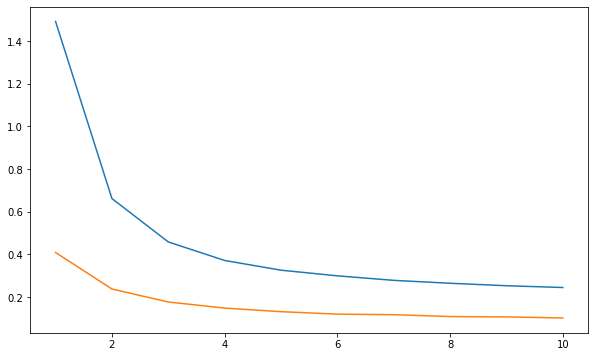

In [17]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

x = [i for i in range(1, hyper.epochs+1)]
y1 = mf_loss
y2 = bpr_loss

ax.plot(x, y1)
ax.plot(x, y2)

plt.show()

In [18]:
def getPredictedFullMatrix(user_embedding, item_embedding, global_mean, user_bias, item_bias):

    num_users = user_embedding.shape[0]
    num_items = item_embedding.shape[0]

    matrix_multiplied_with_bias = np.ones(shape=(num_users, num_items))

    if global_mean is None:
        return user_embedding @ item_embedding.T
    else:
        values = [
            user_embedding @ item_embedding.T,
            matrix_multiplied_with_bias * item_bias,
            np.array([user_bias]).T * matrix_multiplied_with_bias,
            matrix_multiplied_with_bias * global_mean
        ]
        return sum(values)

In [19]:
user_embedding = model_mf.user_embedding.weight.data.detach().cpu().numpy()
item_embedding = model_mf.item_embedding.weight.data.detach().cpu().numpy()
user_biase_embedding = np.squeeze(model_mf.user_bias_embedding.weight.data.detach().cpu().numpy())
item_biase_embedding = np.squeeze(model_mf.item_bias_embedding.weight.data.detach().cpu().numpy())

predict = pd.DataFrame(
    getPredictedFullMatrix(user_embedding, item_embedding, global_mean, user_biase_embedding, item_biase_embedding),
    columns = data.set_movies,
    index = data.set_users
)

predict

,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
0,4.689483,3.575229,4.513450,2.998103,4.875282,4.408030,2.449848,3.646189,3.034403,3.452409,...,4.441032,4.581538,4.178109,4.403262,4.340701,4.246437,5.048597,4.862494,5.281557,3.773314
1,4.627876,4.336096,4.342385,3.473666,4.691597,3.175901,4.085804,4.612026,4.382684,3.811994,...,4.595633,5.035953,4.224408,4.058438,4.476663,3.982890,4.559601,4.743816,5.385302,4.185512
2,3.016190,3.149055,0.344930,1.289803,1.378903,3.378115,2.819276,-0.907448,0.818480,2.806827,...,4.332988,4.388939,3.482871,2.708053,2.889636,2.997909,3.370863,4.155338,4.781958,2.512744
3,3.251019,3.588310,3.050722,1.836939,2.652235,3.600753,2.101373,3.145765,1.265155,2.292165,...,2.735801,3.223545,3.589657,3.951657,3.202153,3.273953,4.283572,3.716254,3.534183,2.859826
4,4.268290,3.908867,1.759764,1.582589,3.890734,2.876808,3.401522,2.327524,3.514471,2.497793,...,5.675385,5.768949,5.118394,3.787526,3.436669,3.842393,3.748997,5.043417,4.842300,2.907836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,3.839025,3.123975,3.432623,2.622404,2.787986,4.015721,2.629791,3.288613,2.023435,3.004912,...,3.557389,3.485544,3.918252,4.005725,3.395095,3.808558,3.656519,3.478156,3.396420,3.333128
606,3.628231,4.098181,4.330986,4.282894,4.091636,3.899693,3.098940,3.335688,3.396100,3.509620,...,4.572393,4.521976,4.419273,3.394211,3.896777,3.846544,4.755417,5.038062,3.525161,3.724340
607,2.674081,2.328694,1.995826,2.929720,1.676676,4.218599,2.973762,3.498707,3.334999,3.556590,...,4.227307,3.785642,4.098510,3.943209,3.795511,3.975129,3.879058,3.661006,3.204340,3.880761
608,3.133214,2.692760,2.619822,2.706076,2.615097,4.541626,2.855276,1.796524,2.129480,3.706346,...,4.279027,4.063949,4.083903,3.489988,3.318610,3.519682,3.984520,3.977219,4.084922,3.205494
